### CITS4404 Practical Project

# Camo Worms!

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [1]:
import time

import matplotlib as mpl
import cv2
import numpy as np

from src.image_loading import *
from src.image_manipulation import *
from src.plotting import *
from src.algorithms.greedy import *
from src.algorithms.base_score import *
from src.bezier import *
from src.worm_mask import filter_out_close_points

from typing import Callable

# Controls the size of the plots.
mpl.rcParams['figure.dpi']= 140


# 1. Source Image

## 1.1. Load the source image

Loads the grayscale image and crops it into a NumPy array.

shape (max, min, mean, std. deviation)
(240, 720) (210.0, 0.0, 49.7, 34.4)


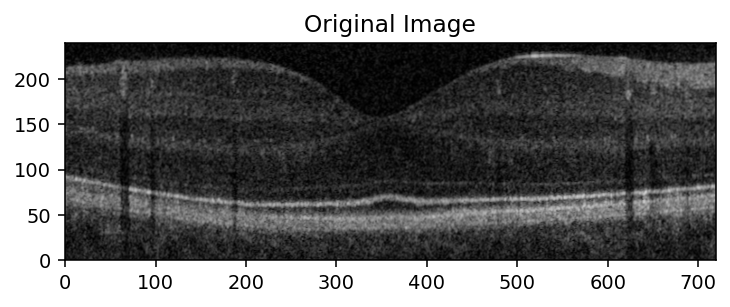

In [2]:
def draw_image(image):
    """ Draws the grayscale image with black as 0 and white as 255. """
    # use vmin and vmax to stop imshow from scaling
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')


image = crop(load_image("images", "original"), (320, 560, 160, 880))

print("shape (max, min, mean, std. deviation)")
print("{} ({}, {}, {}, {})".format(
    np.shape(image), np.max(image), np.min(image),
    round(float(np.mean(image)), 1), round(float(np.std(image)), 1)
))
draw_image(image)
plt.title("Original Image")
plt.show()


## 1.2. Traditional Image Processing

Traditional image processing techniques such as blur, constant convolutions, median windows, and FFT denoising can be used to reduce the noise in an image.

Blurred Image: shape=(240, 720), min=2.16, mean=49.68, max=161.90


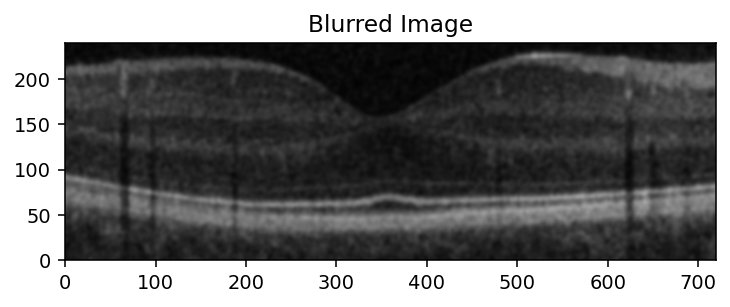

Mean Windowed Image: shape=(240, 720), min=0.00, mean=49.57, max=192.78


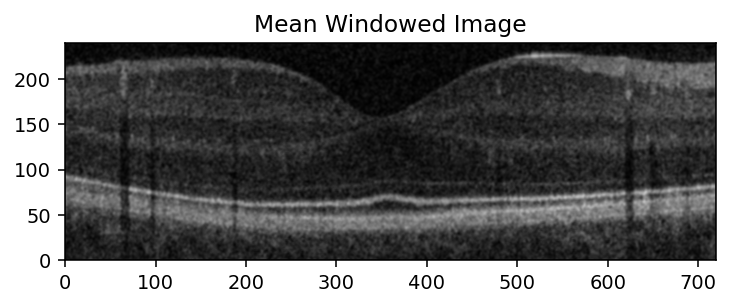

Median Windowed Image: shape=(240, 720), min=0.00, mean=49.66, max=197.00


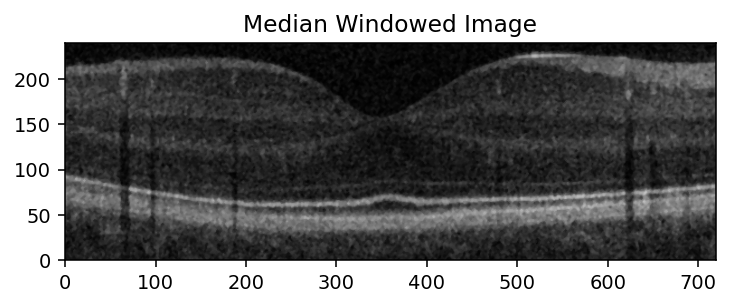

FFT Denoise Image: shape=(240, 720), min=0.00, mean=49.68, max=194.30


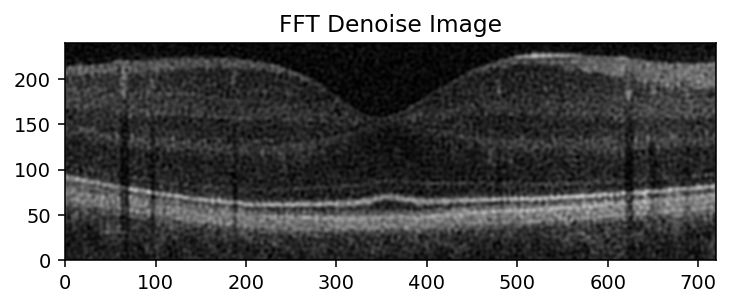

Original Image: shape=(240, 720), min=0.00, mean=49.68, max=210.00


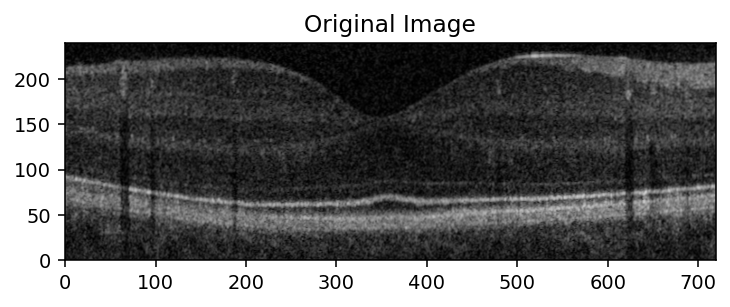

In [3]:
def test_traditional_approach(image, method: Callable, title: str):
    """ Plots the application of a traditional image processing method. """
    processed = method(image)
    print("{}: shape={}, min={:.2f}, mean={:.2f}, max={:.2f}".format(
        title, processed.shape, np.amin(processed), np.mean(processed), np.amax(processed)
    ))
    draw_image(processed)
    plt.title(title)
    plt.show()


test_traditional_approach(image, blur, "Blurred Image")
test_traditional_approach(image, mean_window, "Mean Windowed Image")
test_traditional_approach(image, median_window, "Median Windowed Image")
test_traditional_approach(image, fft_denoise, "FFT Denoise Image")
test_traditional_approach(image, lambda x: x, "Original Image")

## 1.3. Brightening the Image

The above traditional approaches show that there are many ways to reduce noise in an image, but each has their own limitations and benefits. From the above, the median filter looks the best for our purposes of maintaining clear lines in the image for our worms to follow.

However, the image still contains some trends that are very faint compared to others in the image. This can be helped by brightening and darkening the images based upon the brightness if their surroundings.

Scaled Image: shape=(240, 720), min=0.00, mean=60.32, max=255.00


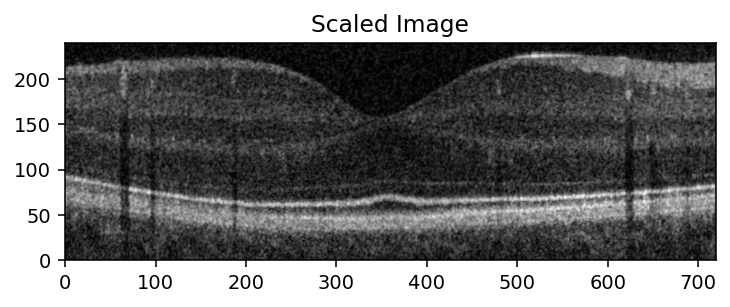

Extremify Image: shape=(240, 720), min=0.00, mean=51.69, max=255.00


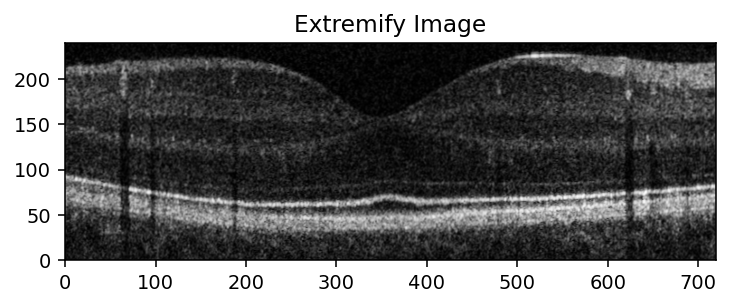

Locally Brightened Image: shape=(240, 720), min=-2.17, mean=53.61, max=252.22


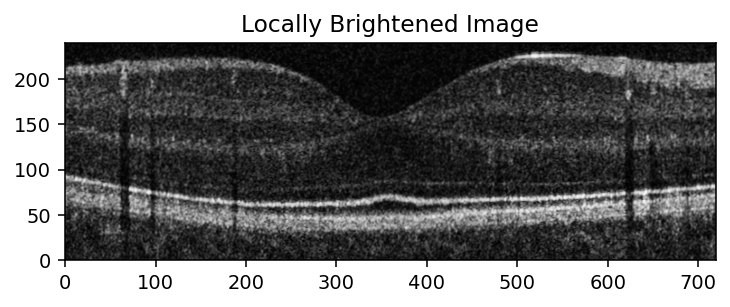

Edge Enhanced Image: shape=(240, 720), min=0.00, mean=52.11, max=249.83


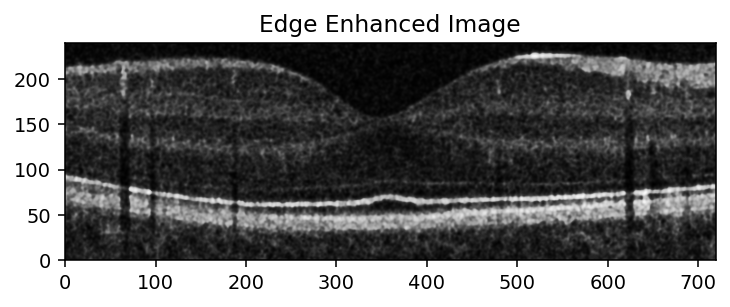

Original Image: shape=(240, 720), min=0.00, mean=49.68, max=210.00


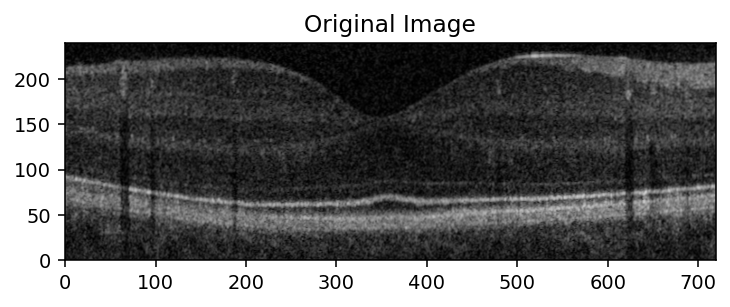

In [4]:
test_traditional_approach(image, scale_brighten, "Scaled Image")
test_traditional_approach(image, extremify, "Extremify Image")
test_traditional_approach(image, local_brighten, "Locally Brightened Image")
test_traditional_approach(image, edge_enhance, "Edge Enhanced Image")
test_traditional_approach(image, lambda x: x, "Original Image")

With these basic image transformation methods, we can enhance the lines in the image, but not very well. Hopefully our worms can do a better job.

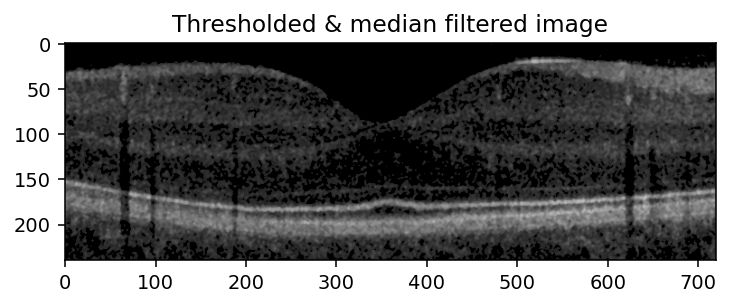

In [5]:
def remove_noise():
    originalImage = cv2.imread("images/original.png")
    grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 30, 255, cv2.THRESH_BINARY)

    for j in range(0, originalImage.shape[0]):
        for i in range(0, originalImage.shape[1]):
            if blackAndWhiteImage[j,i] == 0:
                originalImage[j,i] = (0,0,0)
    median_blur= cv2.medianBlur(originalImage, 3)

    plt.imshow(median_blur[320:560, 160: 880], vmin=0, vmax=255, cmap='gray')
    plt.title("Thresholded & median filtered image")
    plt.show()

    cv2.imwrite("images/Thresholed Image.png", originalImage)
    cv2.imwrite("images/Median Blur.png", median_blur)

remove_noise()


# 2. Worm Representation

The camouflage worms are represented by bezier curves, and are specified in src/worm.py.

## 2.1. Generating Random Worms

In [6]:
def generate_random_clew(size: int, imshape: Tuple[int, int]):
    """ Generates a random clew of size worms. """
    clew = []
    for i in range(size):
        clew.append(CamoWorm.random(imshape))
    return clew

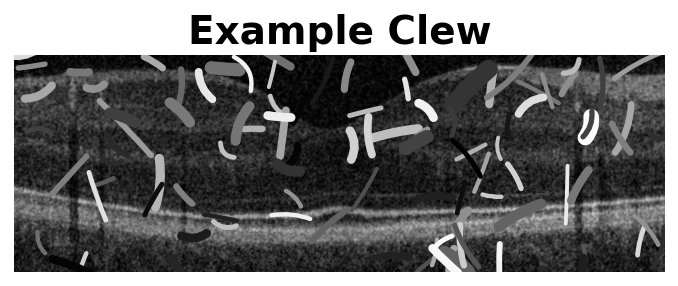

In [7]:
# Initialise clew of 100 and draw

clew = generate_random_clew(100, image.shape)
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.plot(title="Example Clew")

## 2.2. Example Camo Worms

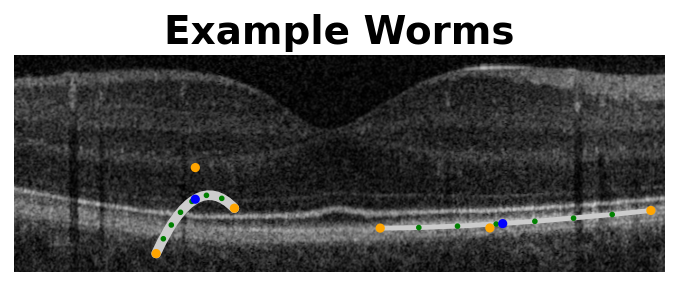

In [8]:
# Draw a single worm along with control points and some sample points

example_worm = CamoWorm(200, 80, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
example_worm_2 = CamoWorm(540, 53, 150, np.pi/50, -30, np.pi/12, 5, 0.8)


def draw_example_bezier_png():
    drawing = Drawing(image)
    for worm in [example_worm, example_worm_2]:
        drawing.add_worms(worm)
        drawing.add_dots(worm.bezier(np.linspace(0, 1, num=8)), radius=2, color='green')
        drawing.add_dots(worm.control_points(), color='orange')
        drawing.add_dots((worm.x, worm.y), color='blue')

    drawing.plot(title="Example Worms")


draw_example_bezier_png()

## 3. Determine what is beneath a worm

Firstly, we will need to determine what pixels are beneath the worm. This is done by creating a mask based on the distance to the worm. To simplify this calculation, we estimate the distance to the worm as the minimum distance to one of N points along the worm. This mask can then be used to filter out only the pixels of the image that fall under the worm.


## 3.1. Reduce the number of points in a curve

The calculation of points on a bezier curve does not give points that are uniformly far apart. Therefore, some sections of the curve would be much more dense than other areas. This wastes computation time. Therefore, the function below filters out the set of points along a curve to only include points that are a certain distance apart.


FastBezierSegment t_create = 0.002 +- 0.001 ms
FastBezierSegment t_eval = 0.017 +- 0.001 ms
FastBezierSegment t_filter = 0.178 +- 7.840 ms


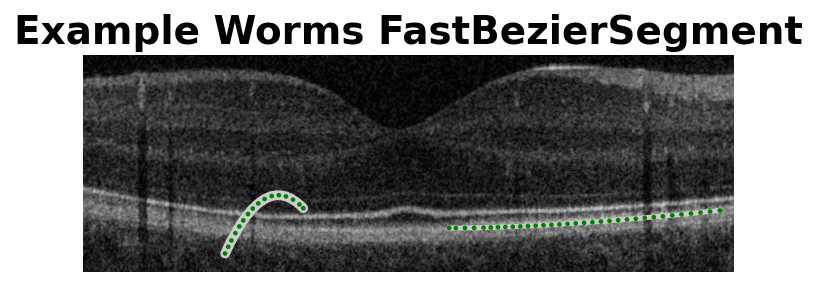

ConsistentBezierSegment t_create = 0.012 +- 0.001 ms
ConsistentBezierSegment t_eval = 0.013 +- 0.001 ms
ConsistentBezierSegment t_filter = 0.000 +- 0.000 ms


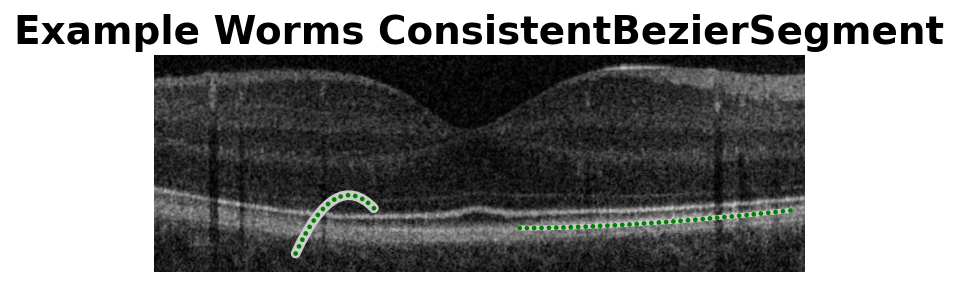

In [9]:
for impl in [FastBezierSegment, ConsistentBezierSegment]:
    drawing = Drawing(image)
    t_create = []
    t_eval = []
    t_filter = []

    for worm in [example_worm, example_worm_2]:
        ctrl_pts = worm.control_points()
        num_t_values = int(impl(ctrl_pts).length / 8) + 1 if impl is ConsistentBezierSegment else 100
        point_t_values = np.linspace(0, 1, num=num_t_values)

        intermediate_pts = None
        for i in range(1000):
            t0 = time.perf_counter()
            bezier = impl(ctrl_pts)
            t_create.append(time.perf_counter() - t0)

            t0 = time.perf_counter()
            intermediate_pts = bezier(point_t_values)
            t_eval.append(time.perf_counter() - t0)

            if impl != ConsistentBezierSegment:
                t0 = time.perf_counter()
                intermediate_pts = filter_out_close_points(intermediate_pts, point_interval=8)
                t_filter.append(time.perf_counter() - t0)
            else:
                t_filter.append(0)

        drawing.add_worms(worm)
        drawing.add_dots(intermediate_pts, radius=1.5, color='green')

    t_create = 1000 * np.array(t_create, dtype=float)
    t_eval = 1000 * np.array(t_eval, dtype=float)
    t_filter = 1000 * np.array(t_filter, dtype=float)

    print(f"{impl.__name__} t_create = {np.mean(t_create):.3f} +- {np.std(t_create):.3f} ms")
    print(f"{impl.__name__} t_eval = {np.mean(t_eval):.3f} +- {np.std(t_eval):.3f} ms")
    print(f"{impl.__name__} t_filter = {np.mean(t_filter):.3f} +- {np.std(t_filter):.3f} ms")
    drawing.plot(title="Example Worms {}".format(impl.__name__))


Therefore, by using a consistency map we can accurately approximate evenly spaced points along a Bezier curve. We can also sample more points and then filter them based upon distance. However, this leads to a higher cost at evaluation, but a cheaper cost at initialisation.

## 3.2. Generation of circles

We create the mask by drawing a series of circles into a NumPy array. These circle masks can be relatively expensive to compute compared to the generation of the mask. Therefore, we can cache them to save on computation time.

## 3.3. Generate a worm mask from a bezier curve

To save on computation time, the masks that we generate only encompass the bounding box of the worm. Offsets are then used to relate the mask to the subset of the image that they represent.

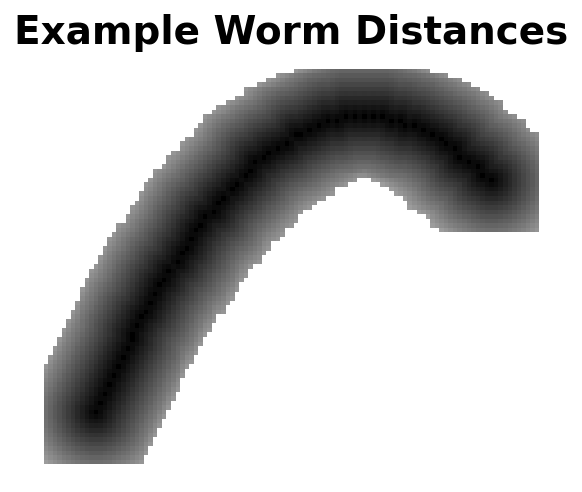

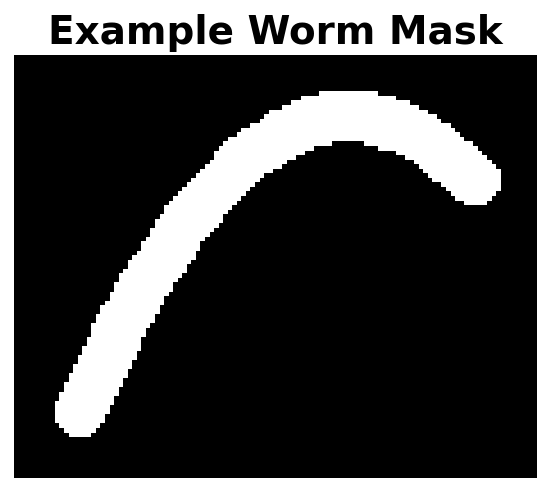

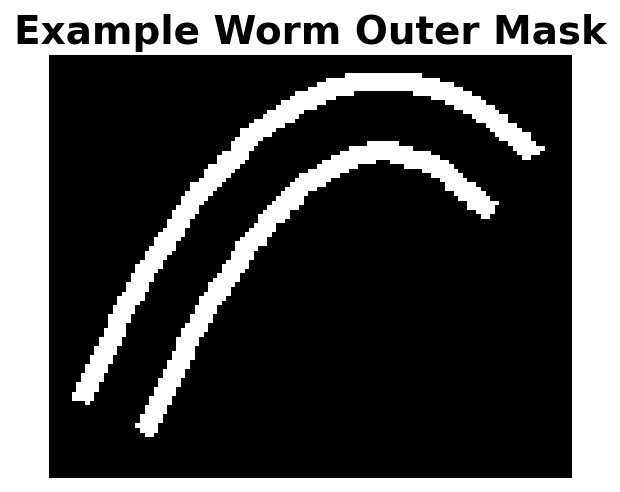

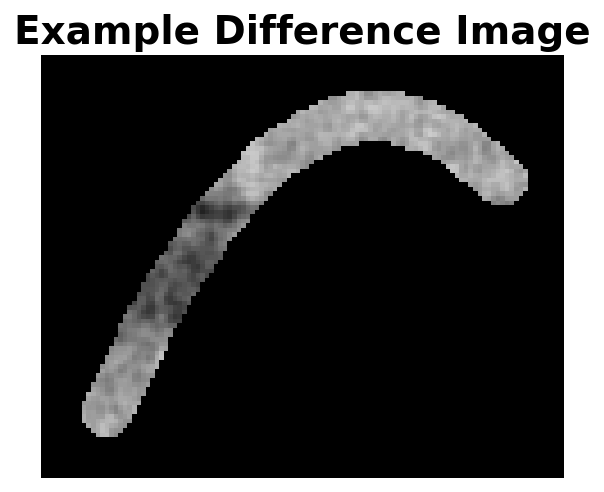

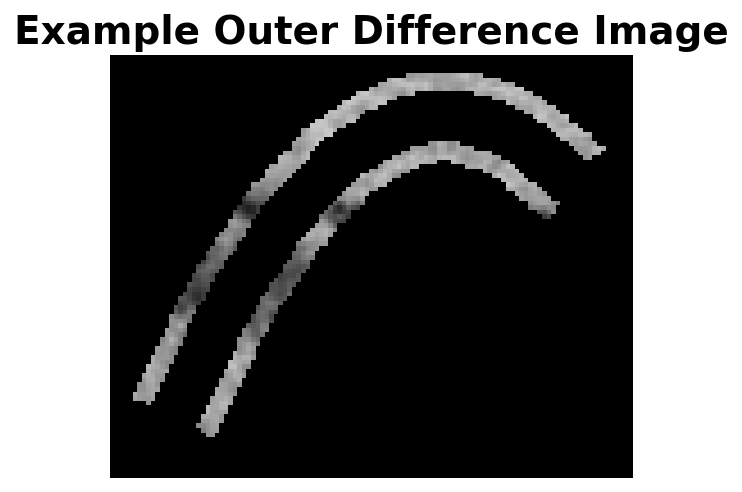

In [10]:
# Compare the generated mask with the worm used in the example above.
worm_mask = WormMask.from_worm(example_worm, image, high_qual_distances=True)
outer_mask = worm_mask.create_outer_mask()
Drawing(10 * np.sqrt(worm_mask.distances)).plot(title="Example Worm Distances")
Drawing(worm_mask.mask * 255).plot(title="Example Worm Mask")
Drawing(outer_mask.mask * 255).plot(title="Example Worm Outer Mask")
Drawing(worm_mask.difference_image(example_worm.colour) * 255).plot(title="Example Difference Image")
Drawing(outer_mask.difference_image(example_worm.colour) * 255).plot(title="Example Outer Difference Image")


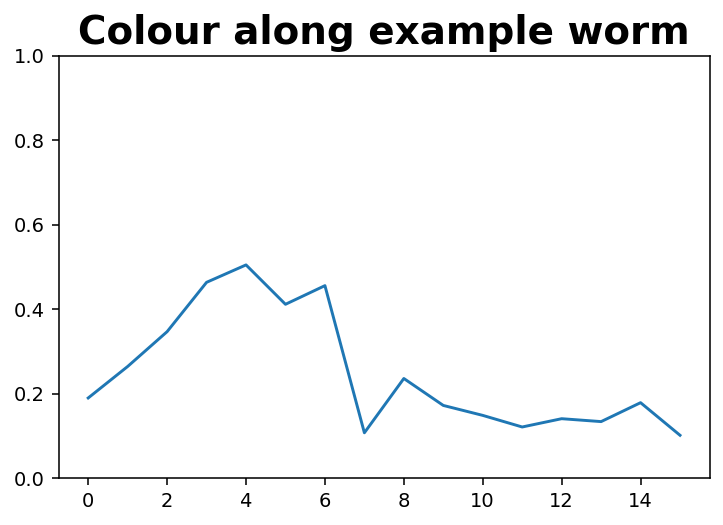

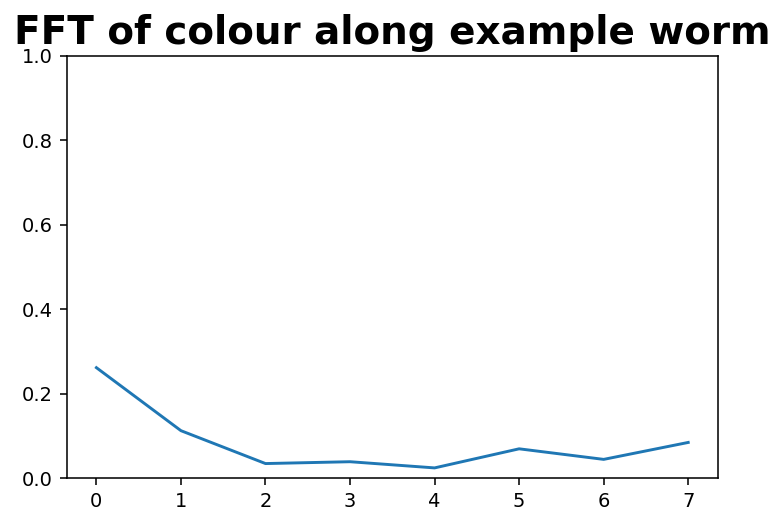

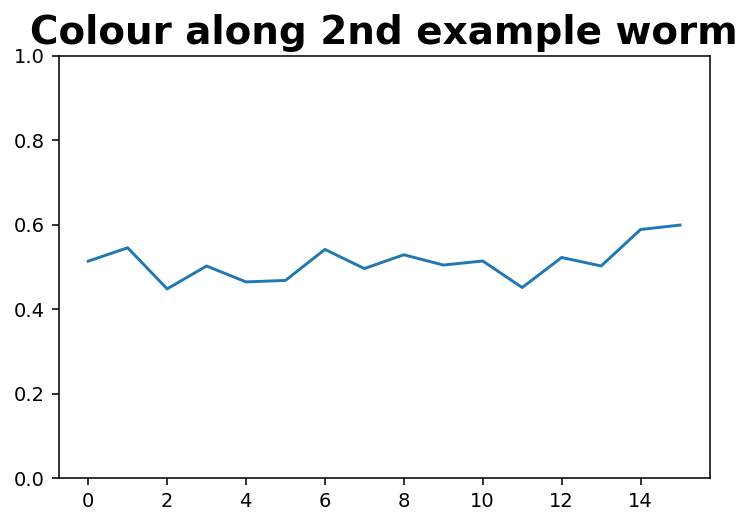

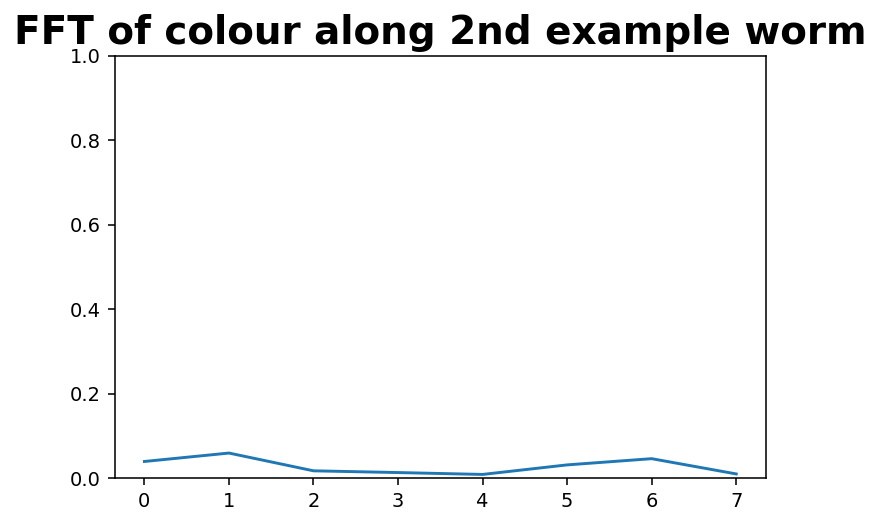

Area = 1486.0, Intersection = 0.682
Intersection of 2 Example Worms = 0.000


In [11]:
colours_under_worm = worm_mask.colour_under_points()
plt.title("Colour along example worm", fontdict={"fontsize": 20, "fontweight": 700})
plt.plot(colours_under_worm)
plt.ylim(0, 1)
plt.show()

plt.title("FFT of colour along example worm", fontdict={"fontsize": 20, "fontweight": 700})
plt.plot(fft_magnitudes(colours_under_worm))
plt.ylim(0, 1)
plt.show()

worm_mask_2 = WormMask.from_worm(example_worm_2, image)
colours_under_worm_2 = worm_mask_2.colour_under_points()
plt.title("Colour along 2nd example worm", fontdict={"fontsize": 20, "fontweight": 700})
plt.plot(colours_under_worm_2)
plt.ylim(0, 1)
plt.show()

plt.title("FFT of colour along 2nd example worm", fontdict={"fontsize": 20, "fontweight": 700})
plt.plot(fft_magnitudes(colours_under_worm_2))
plt.ylim(0, 1)
plt.show()

example_intersecting_worm = example_worm.copy(x=example_worm.x + 5)
intersecting_worm_mask = WormMask.from_worm(example_intersecting_worm, image)
print("Area = {:.1f}, Intersection = {:.3f}".format(
    worm_mask.area, worm_mask.intersection(intersecting_worm_mask))
)

print("Intersection of 2 Example Worms = {:.3f}".format(
    worm_mask.intersection(WormMask.from_worm(example_worm_2, image)))
)


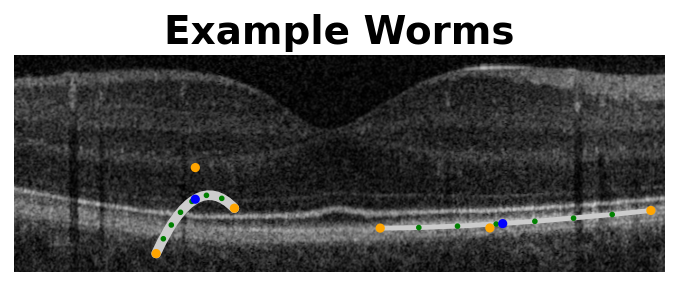

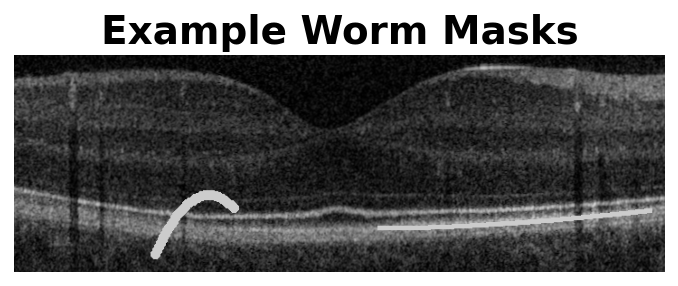

In [12]:
draw_example_bezier_png()

# Draw the masks to visualise their similarities to the real curves.
def draw_example_worm_masks(title="Example Worm Masks"):
    image_with_worm_masks = image.copy()
    for worm in [example_worm, example_worm_2]:
        mask = WormMask.from_worm(worm, image)
        mask.draw_into(image_with_worm_masks, worm.colour * 255.0)
    Drawing(image_with_worm_masks).plot(title=title)


draw_example_worm_masks()


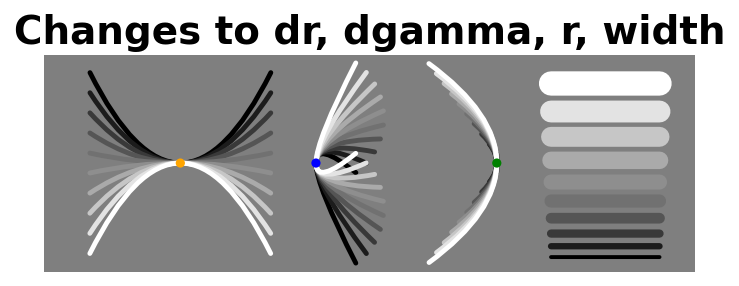

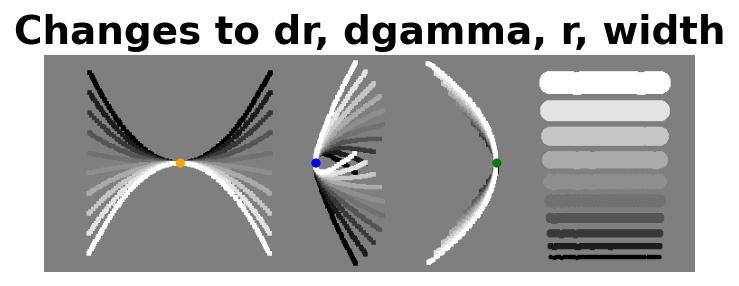

In [13]:
h, w = image.shape
test_param_worms = []

test_param_worm_dr = CamoWorm(150, h // 2, 100, 0, 0, np.pi/2, 5, 1)
for colour in np.linspace(0, 1, 10):
    test_param_worms.append(test_param_worm_dr.copy(
        colour=colour, dr=2*(colour-0.5)*200
    ))

test_param_worm_dgamma = CamoWorm(300, h // 2, 50, math.pi/2, 150, np.pi/2, 5, 1)
for colour in np.linspace(0, 1, 10):
    test_param_worms.append(test_param_worm_dgamma.copy(
        colour=colour, dgamma=math.pi*(0.2 + 0.6 * colour)
    ))

test_param_worm_r = CamoWorm(500, h // 2, 100, -math.pi/2, 0, np.pi/2, 5, 1)
for colour in np.linspace(0, 1, 10):
    test_param_worms.append(test_param_worm_r.copy(
        colour=colour, r=10 + 100*colour, dr=150*colour
    ))

test_param_worm_width = CamoWorm(620, h // 2, 60, 0, 0, np.pi/2, 5, 1)
width_worm_curr_y = 16
for colour in np.linspace(0, 1, 10):
    width = 4+21*colour
    test_param_worms.append(test_param_worm_width.copy(
        colour=colour, y=width_worm_curr_y, width=width
    ))
    width_worm_curr_y += width + 8

drawing = Drawing(np.zeros(image.shape) + 127)
drawing.add_worms(test_param_worms)
drawing.add_dots((test_param_worm_dr.x, test_param_worm_dr.y), color='orange')
drawing.add_dots((test_param_worm_dgamma.x, test_param_worm_dgamma.y), color='blue')
drawing.add_dots((test_param_worm_r.x, test_param_worm_r.y), color='green')
drawing.plot(title="Changes to dr, dgamma, r, width")

param_image = np.zeros(image.shape) + 127
for worm in test_param_worms:
    WormMask.from_worm(worm, param_image).draw_into(param_image, worm.colour * 255)
drawing = Drawing(param_image)
drawing.add_dots((test_param_worm_dr.x, test_param_worm_dr.y), color='orange')
drawing.add_dots((test_param_worm_dgamma.x, test_param_worm_dgamma.y), color='blue')
drawing.add_dots((test_param_worm_r.x, test_param_worm_r.y), color='green')
drawing.plot(title="Changes to dr, dgamma, r, width")


# 4. Search Optimisation
Determining the colour and width of the worms by evolution is particularly difficult. However, we can just use the mean colour under the mask for the colour of the worm. Additionally, we can use search over many width values to determine the best width for the worm.

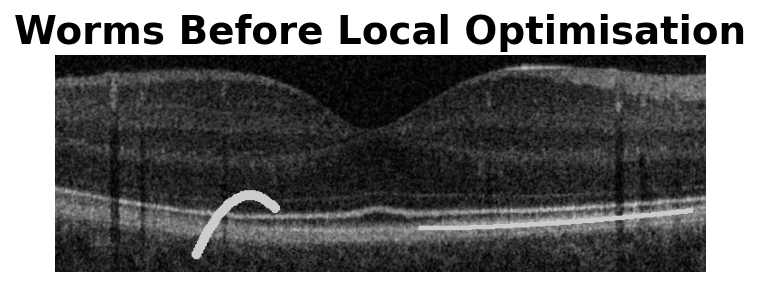

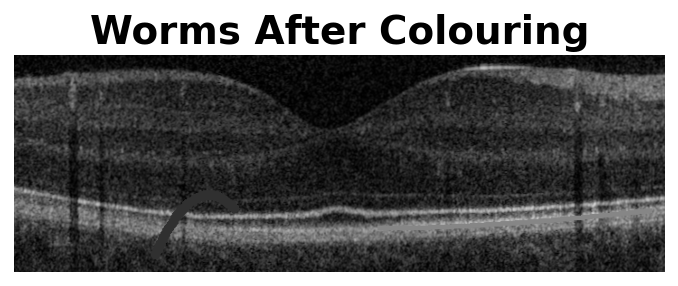

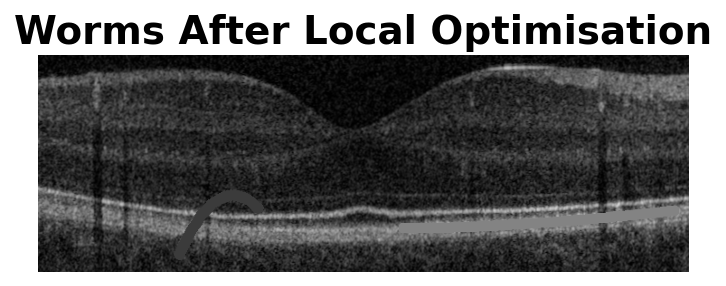

In [14]:
draw_example_worm_masks(title="Worms Before Local Optimisation")

# Set the worms to the most common colour under them.
example_mask = WormMask.from_worm(example_worm, image)
example_mask_2 = WormMask.from_worm(example_worm_2, image)
example_worm.colour = example_mask.median_colour()
example_worm_2.colour = example_mask_2.median_colour()
draw_example_worm_masks(title="Worms After Colouring")

# Search for the best width for the example worms.
locally_optimise_worm(image, example_worm)
locally_optimise_worm(image, example_worm_2)
draw_example_worm_masks(title="Worms After Local Optimisation")


# 5. Optimisation Algorithm

## 5.1 Greedy Search
This algorithm randomly mutates a population of camo worms, and only keeps the mutations that improve the score of the worms.

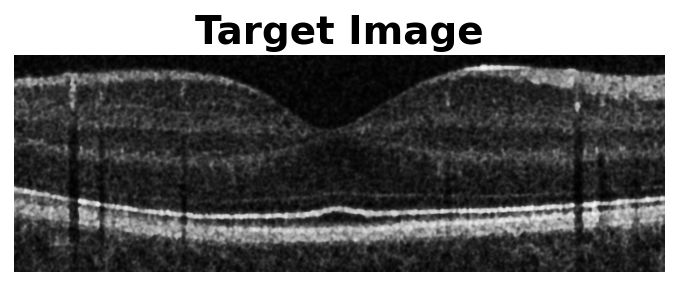

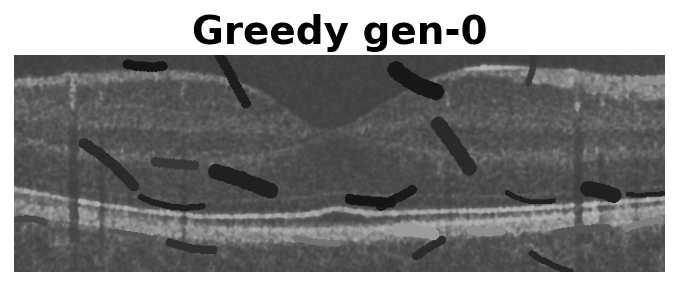

In [15]:
ga = GreedyClewEvolution(image, 25)
ga.plot_clew(show_target_image=True)


## 5.2. Randomly Mutating Worms
The algorithm randomly mutates the worms to find potential improvements to them. These mutations are more drastic the lower the score of the worm, and less drastic the higher the score of the worm.

There is also a small random chance that a good worm will be randomly mutated as though it scored as poorly as possible. This is done as an attempt to allow worms to escape local minima.

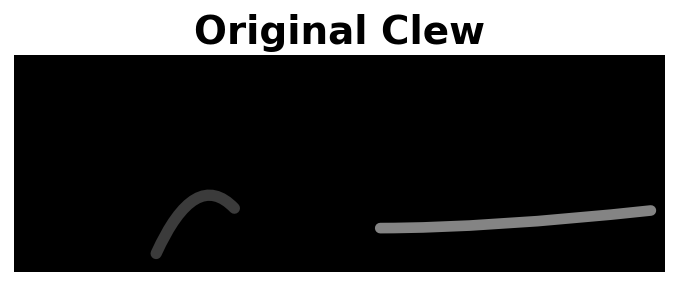

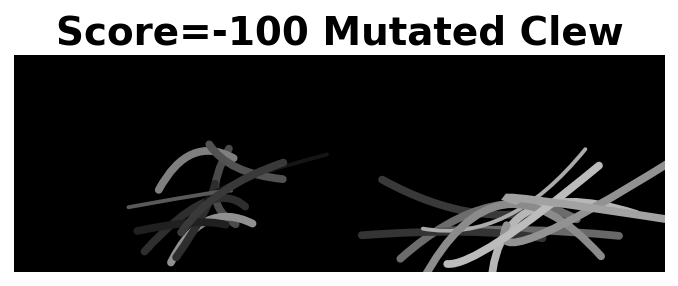

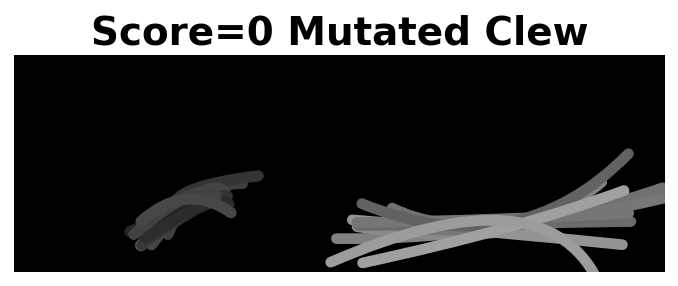

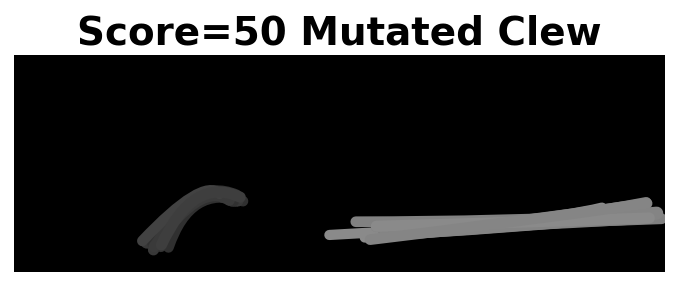

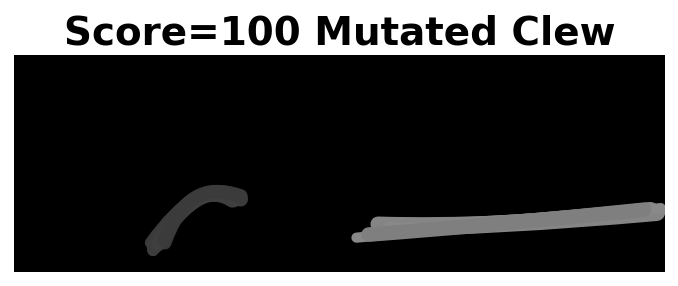

In [16]:
ga_mutate_test = GreedyClewEvolution(image, 0)
ga_mutate_test.add_worm(example_worm)
ga_mutate_test.add_worm(example_worm_2)

drawing = Drawing(np.zeros(image.shape) + 0.5)
drawing.add_worms(ga_mutate_test.clew)
drawing.plot(title="Original Clew")

mutated_worms = [ga_mutate_test.random_mutate(example_worm, -100, drastic_chance=0) for i in range(10)]
mutated_worms += [ga_mutate_test.random_mutate(example_worm_2, -100, drastic_chance=0) for i in range(10)]
drawing = Drawing(np.zeros(image.shape) + 0.5)
drawing.add_worms(mutated_worms)
drawing.plot(title="Score=-100 Mutated Clew")

mutated_worms = [ga_mutate_test.random_mutate(example_worm, 0, drastic_chance=0) for i in range(10)]
mutated_worms += [ga_mutate_test.random_mutate(example_worm_2, 0, drastic_chance=0) for i in range(10)]
drawing = Drawing(np.zeros(image.shape) + 0.5)
drawing.add_worms(mutated_worms)
drawing.plot(title="Score=0 Mutated Clew")

mutated_worms = [ga_mutate_test.random_mutate(example_worm, 50, drastic_chance=0) for i in range(10)]
mutated_worms += [ga_mutate_test.random_mutate(example_worm_2, 50, drastic_chance=0) for i in range(10)]
drawing = Drawing(np.zeros(image.shape) + 0.5)
drawing.add_worms(mutated_worms)
drawing.plot(title="Score=50 Mutated Clew")

mutated_worms = [ga_mutate_test.random_mutate(example_worm, 100, drastic_chance=0) for i in range(10)]
mutated_worms += [ga_mutate_test.random_mutate(example_worm_2, 100, drastic_chance=0) for i in range(10)]
drawing = Drawing(np.zeros(image.shape))
drawing.add_worms(mutated_worms)
drawing.plot(title="Score=100 Mutated Clew")


## 5.3. Running the Greedy Algorithm
Now, we can run the greedy algorithm using our basic functions as a baseline test.

Generation 1: SSIM = 0.291, Scores = 80 ± 50, [12, 202], Worms = 25  (took 0.40 sec)


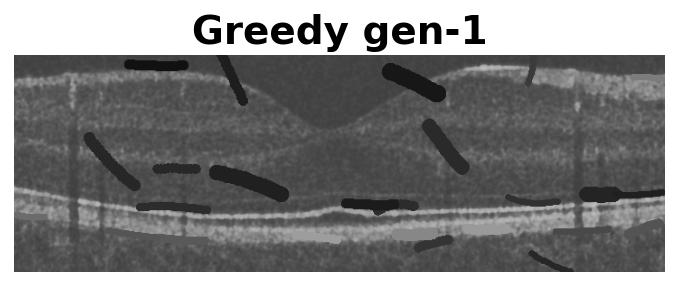

In [17]:
ga.run_generation()
ga.plot_clew()

Generation 2: SSIM = 0.290, Scores = 102 ± 59, [12, 224], Worms = 25  (took 0.39 sec)
Generation 3: SSIM = 0.291, Scores = 123 ± 70, [13, 246], Worms = 25  (took 0.40 sec)
Generation 4: SSIM = 0.291, Scores = 139 ± 77, [13, 279], Worms = 25  (took 0.40 sec)
Generation 5: SSIM = 0.292, Scores = 152 ± 84, [13, 304], Worms = 25  (took 0.41 sec)
Generation 6: SSIM = 0.293, Scores = 162 ± 90, [13, 337], Worms = 25  (took 0.41 sec)
Generation 7: SSIM = 0.294, Scores = 171 ± 91, [18, 350], Worms = 25  (took 0.42 sec)
Generation 8: SSIM = 0.294, Scores = 179 ± 96, [18, 362], Worms = 25  (took 0.42 sec)
Generation 9: SSIM = 0.298, Scores = 186 ± 97, [18, 371], Worms = 25  (took 0.43 sec)
Generation 10: SSIM = 0.299, Scores = 195 ± 101, [20, 388], Worms = 25  (took 0.42 sec)


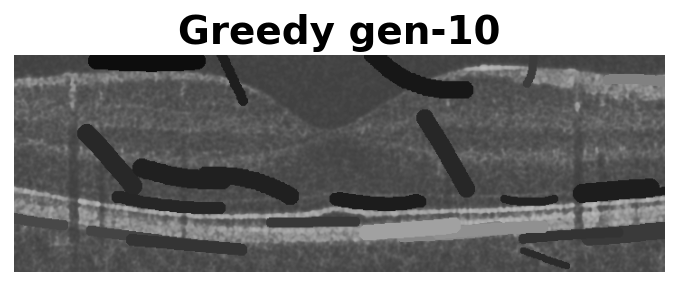

In [18]:
ga.run_generations(9)
ga.plot_clew()

Generation 11: SSIM = 0.298, Scores = 201 ± 104, [21, 388], Worms = 25  (took 0.46 sec)
Generation 12: SSIM = 0.300, Scores = 204 ± 106, [21, 401], Worms = 25  (took 0.44 sec)
Generation 13: SSIM = 0.300, Scores = 207 ± 107, [21, 401], Worms = 25  (took 0.44 sec)
Generation 14: SSIM = 0.301, Scores = 211 ± 109, [22, 410], Worms = 25  (took 0.44 sec)
Generation 15: SSIM = 0.300, Scores = 213 ± 110, [22, 410], Worms = 25  (took 0.44 sec)
Generation 16: SSIM = 0.301, Scores = 216 ± 113, [22, 431], Worms = 25  (took 0.44 sec)
Generation 17: SSIM = 0.300, Scores = 219 ± 114, [22, 439], Worms = 25  (took 0.45 sec)
Generation 18: SSIM = 0.300, Scores = 222 ± 116, [22, 439], Worms = 25  (took 0.45 sec)
Generation 19: SSIM = 0.301, Scores = 226 ± 117, [22, 442], Worms = 25  (took 0.45 sec)
Generation 20: SSIM = 0.302, Scores = 229 ± 119, [22, 452], Worms = 25  (took 0.45 sec)


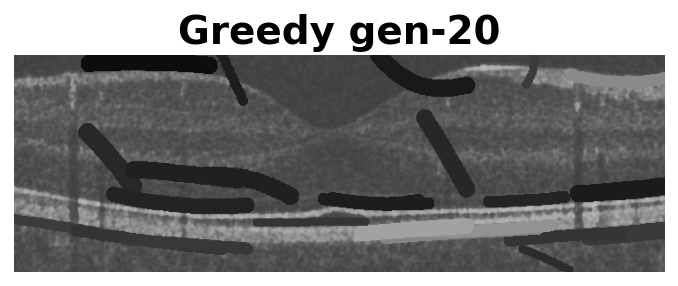

In [19]:
ga.run_generations(10)
ga.plot_clew()

Generation 21: SSIM = 0.303, Scores = 234 ± 124, [22, 481], Worms = 25  (took 0.46 sec)
Generation 22: SSIM = 0.303, Scores = 235 ± 124, [22, 481], Worms = 25  (took 0.45 sec)
Generation 23: SSIM = 0.303, Scores = 237 ± 126, [22, 481], Worms = 25  (took 0.46 sec)
Generation 24: SSIM = 0.303, Scores = 239 ± 126, [22, 481], Worms = 25  (took 0.46 sec)
Generation 25: SSIM = 0.304, Scores = 241 ± 126, [23, 482], Worms = 25  (took 0.46 sec)
Generation 26: SSIM = 0.304, Scores = 244 ± 125, [29, 482], Worms = 25  (took 0.46 sec)
Generation 27: SSIM = 0.304, Scores = 245 ± 125, [29, 482], Worms = 25  (took 0.46 sec)
Generation 28: SSIM = 0.305, Scores = 247 ± 124, [38, 482], Worms = 25  (took 0.47 sec)
Generation 29: SSIM = 0.305, Scores = 250 ± 121, [50, 482], Worms = 25  (took 0.47 sec)
Generation 30: SSIM = 0.305, Scores = 253 ± 119, [56, 482], Worms = 25  (took 0.47 sec)


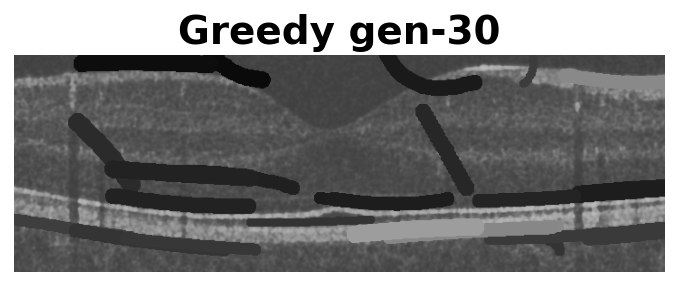

In [20]:
ga.run_generations(10)
ga.plot_clew()

Generation 31: SSIM = 0.306, Scores = 256 ± 118, [56, 482], Worms = 25  (took 0.47 sec)
Generation 32: SSIM = 0.306, Scores = 260 ± 120, [56, 508], Worms = 25  (took 0.47 sec)
Generation 33: SSIM = 0.306, Scores = 263 ± 118, [56, 508], Worms = 25  (took 0.47 sec)
Generation 34: SSIM = 0.304, Scores = 264 ± 117, [56, 508], Worms = 25  (took 0.48 sec)
Generation 35: SSIM = 0.306, Scores = 269 ± 116, [56, 508], Worms = 25  (took 0.48 sec)
Generation 36: SSIM = 0.306, Scores = 271 ± 116, [56, 520], Worms = 25  (took 0.48 sec)
Generation 37: SSIM = 0.306, Scores = 273 ± 117, [56, 535], Worms = 25  (took 0.48 sec)
Generation 38: SSIM = 0.307, Scores = 273 ± 117, [56, 535], Worms = 25  (took 0.48 sec)
Generation 39: SSIM = 0.309, Scores = 276 ± 118, [56, 535], Worms = 25  (took 0.49 sec)
Generation 40: SSIM = 0.309, Scores = 278 ± 120, [56, 535], Worms = 25  (took 0.49 sec)


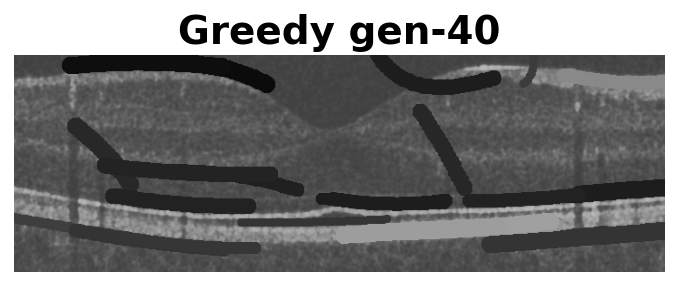

In [21]:
ga.run_generations(10)
ga.plot_clew()

Generation 41: SSIM = 0.309, Scores = 280 ± 122, [56, 551], Worms = 25  (took 0.49 sec)
Generation 42: SSIM = 0.310, Scores = 281 ± 122, [56, 551], Worms = 25  (took 0.49 sec)
Generation 43: SSIM = 0.310, Scores = 282 ± 123, [56, 551], Worms = 25  (took 0.49 sec)
Generation 44: SSIM = 0.310, Scores = 282 ± 123, [56, 551], Worms = 25  (took 0.49 sec)
Generation 45: SSIM = 0.310, Scores = 283 ± 123, [56, 551], Worms = 25  (took 0.49 sec)
Generation 46: SSIM = 0.310, Scores = 283 ± 123, [56, 551], Worms = 25  (took 0.50 sec)
Generation 47: SSIM = 0.310, Scores = 283 ± 123, [56, 551], Worms = 25  (took 0.49 sec)
Generation 48: SSIM = 0.311, Scores = 285 ± 124, [56, 551], Worms = 25  (took 0.49 sec)
Generation 49: SSIM = 0.311, Scores = 285 ± 124, [56, 551], Worms = 25  (took 0.49 sec)
Generation 50: SSIM = 0.311, Scores = 285 ± 125, [56, 551], Worms = 25  (took 0.49 sec)


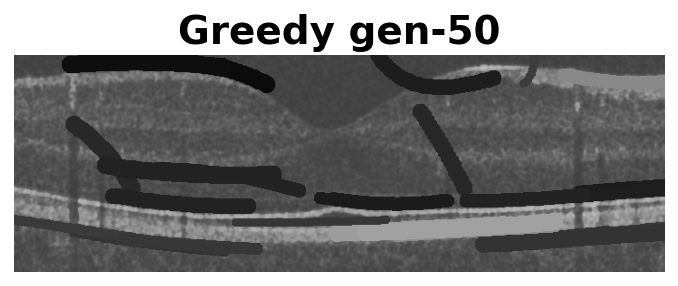

In [22]:
ga.run_generations(10)
ga.plot_clew()

Generation 51: SSIM = 0.310, Scores = 287 ± 126, [56, 551], Worms = 25  (took 0.50 sec)
Generation 52: SSIM = 0.310, Scores = 288 ± 126, [56, 551], Worms = 25  (took 0.50 sec)
Generation 53: SSIM = 0.310, Scores = 289 ± 126, [56, 551], Worms = 25  (took 0.50 sec)
Generation 54: SSIM = 0.310, Scores = 289 ± 126, [56, 551], Worms = 25  (took 0.50 sec)
Generation 55: SSIM = 0.310, Scores = 289 ± 126, [56, 551], Worms = 25  (took 0.50 sec)
Generation 56: SSIM = 0.310, Scores = 289 ± 126, [56, 551], Worms = 25  (took 0.50 sec)
Generation 57: SSIM = 0.310, Scores = 290 ± 127, [56, 551], Worms = 25  (took 0.51 sec)
Generation 58: SSIM = 0.310, Scores = 290 ± 127, [56, 551], Worms = 25  (took 0.51 sec)
Generation 59: SSIM = 0.310, Scores = 291 ± 128, [58, 551], Worms = 25  (took 0.51 sec)
Generation 60: SSIM = 0.310, Scores = 292 ± 128, [58, 551], Worms = 25  (took 0.51 sec)


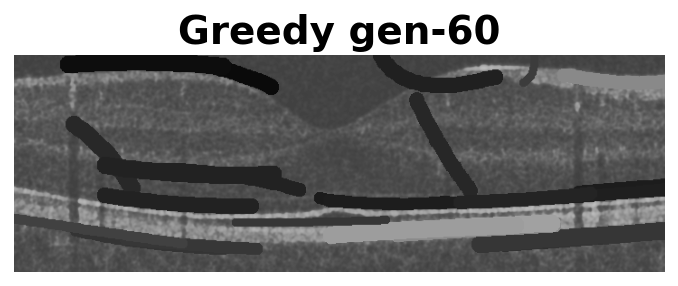

In [23]:
ga.run_generations(10)
ga.plot_clew()

Generation 61: SSIM = 0.311, Scores = 293 ± 129, [58, 551], Worms = 25  (took 0.52 sec)
Generation 62: SSIM = 0.311, Scores = 295 ± 129, [58, 551], Worms = 25  (took 0.52 sec)
Generation 63: SSIM = 0.310, Scores = 296 ± 133, [58, 588], Worms = 25  (took 0.52 sec)
Generation 64: SSIM = 0.311, Scores = 297 ± 133, [58, 588], Worms = 25  (took 0.52 sec)
Generation 65: SSIM = 0.311, Scores = 297 ± 133, [58, 588], Worms = 25  (took 0.57 sec)
Generation 66: SSIM = 0.311, Scores = 298 ± 134, [58, 588], Worms = 25  (took 0.55 sec)
Generation 67: SSIM = 0.311, Scores = 299 ± 134, [58, 588], Worms = 25  (took 0.51 sec)
Generation 68: SSIM = 0.310, Scores = 300 ± 134, [58, 588], Worms = 25  (took 0.50 sec)
Generation 69: SSIM = 0.311, Scores = 300 ± 134, [58, 588], Worms = 25  (took 0.50 sec)
Generation 70: SSIM = 0.311, Scores = 301 ± 135, [58, 588], Worms = 25  (took 0.50 sec)


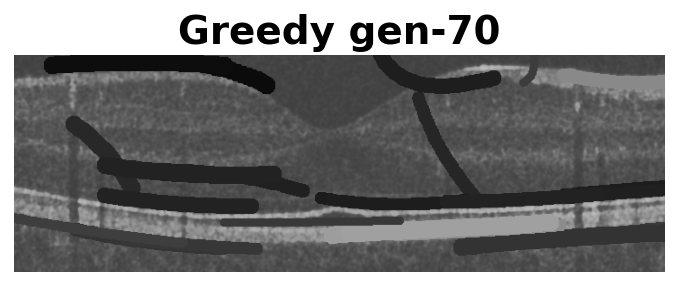

In [24]:
ga.run_generations(10)
ga.plot_clew()

Generation 71: SSIM = 0.311, Scores = 302 ± 135, [58, 588], Worms = 25  (took 0.50 sec)
Generation 72: SSIM = 0.311, Scores = 302 ± 135, [58, 588], Worms = 25  (took 0.50 sec)
Generation 73: SSIM = 0.311, Scores = 303 ± 135, [58, 588], Worms = 25  (took 0.50 sec)
Generation 74: SSIM = 0.311, Scores = 303 ± 135, [58, 588], Worms = 25  (took 0.51 sec)
Generation 75: SSIM = 0.311, Scores = 304 ± 136, [58, 588], Worms = 25  (took 0.51 sec)
Generation 76: SSIM = 0.310, Scores = 304 ± 136, [58, 588], Worms = 25  (took 0.52 sec)
Generation 77: SSIM = 0.310, Scores = 305 ± 136, [58, 588], Worms = 25  (took 0.52 sec)
Generation 78: SSIM = 0.311, Scores = 306 ± 136, [58, 588], Worms = 25  (took 0.51 sec)
Generation 79: SSIM = 0.311, Scores = 306 ± 136, [58, 588], Worms = 25  (took 0.52 sec)
Generation 80: SSIM = 0.312, Scores = 306 ± 137, [58, 598], Worms = 25  (took 0.53 sec)


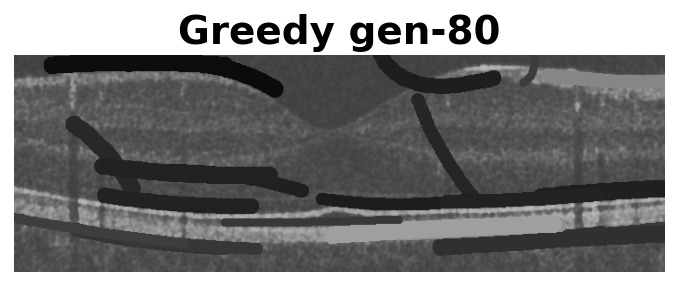

In [25]:
ga.run_generations(10)
ga.plot_clew()

Generation 81: SSIM = 0.313, Scores = 307 ± 137, [58, 598], Worms = 25  (took 0.52 sec)
Generation 82: SSIM = 0.313, Scores = 307 ± 137, [58, 598], Worms = 25  (took 0.52 sec)
Generation 83: SSIM = 0.312, Scores = 308 ± 137, [58, 598], Worms = 25  (took 0.53 sec)
Generation 84: SSIM = 0.313, Scores = 309 ± 137, [58, 598], Worms = 25  (took 0.52 sec)
Generation 85: SSIM = 0.313, Scores = 309 ± 138, [58, 598], Worms = 25  (took 0.52 sec)
Generation 86: SSIM = 0.313, Scores = 310 ± 138, [58, 598], Worms = 25  (took 0.52 sec)
Generation 87: SSIM = 0.313, Scores = 310 ± 138, [58, 598], Worms = 25  (took 0.54 sec)
Generation 88: SSIM = 0.313, Scores = 310 ± 138, [58, 598], Worms = 25  (took 0.55 sec)
Generation 89: SSIM = 0.313, Scores = 312 ± 139, [58, 598], Worms = 25  (took 0.53 sec)
Generation 90: SSIM = 0.314, Scores = 313 ± 139, [58, 598], Worms = 25  (took 0.52 sec)


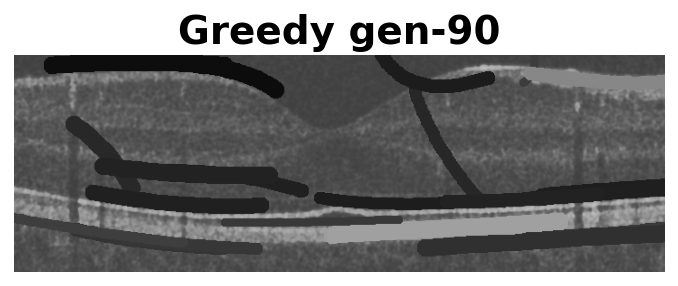

In [26]:
ga.run_generations(10)
ga.plot_clew()

Generation 91: SSIM = 0.314, Scores = 313 ± 139, [58, 598], Worms = 25  (took 0.52 sec)
Generation 92: SSIM = 0.314, Scores = 314 ± 140, [58, 598], Worms = 25  (took 0.53 sec)
Generation 93: SSIM = 0.314, Scores = 314 ± 140, [58, 598], Worms = 25  (took 0.60 sec)
Generation 94: SSIM = 0.315, Scores = 315 ± 140, [58, 598], Worms = 25  (took 0.52 sec)
Generation 95: SSIM = 0.315, Scores = 315 ± 140, [58, 598], Worms = 25  (took 0.51 sec)
Generation 96: SSIM = 0.315, Scores = 316 ± 141, [58, 598], Worms = 25  (took 0.51 sec)
Generation 97: SSIM = 0.315, Scores = 317 ± 141, [58, 598], Worms = 25  (took 0.51 sec)
Generation 98: SSIM = 0.315, Scores = 317 ± 141, [58, 598], Worms = 25  (took 0.51 sec)
Generation 99: SSIM = 0.315, Scores = 318 ± 142, [58, 598], Worms = 25  (took 0.52 sec)
Generation 100: SSIM = 0.315, Scores = 318 ± 142, [58, 598], Worms = 25  (took 0.54 sec)


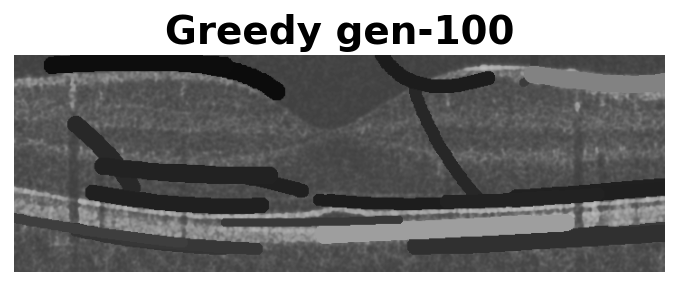

In [27]:
ga.run_generations(10)
ga.plot_clew()

Generation 101: SSIM = 0.315, Scores = 306 ± 152, [1, 598], Worms = 26  (took 0.62 sec)
Generation 102: SSIM = 0.315, Scores = 307 ± 151, [20, 598], Worms = 26  (took 0.54 sec)
Generation 103: SSIM = 0.315, Scores = 309 ± 149, [53, 598], Worms = 26  (took 0.53 sec)
Generation 104: SSIM = 0.315, Scores = 310 ± 149, [58, 598], Worms = 26  (took 0.54 sec)
Generation 105: SSIM = 0.315, Scores = 312 ± 148, [58, 598], Worms = 26  (took 0.53 sec)
Generation 106: SSIM = 0.314, Scores = 313 ± 148, [58, 598], Worms = 26  (took 0.53 sec)
Generation 107: SSIM = 0.314, Scores = 313 ± 147, [58, 598], Worms = 26  (took 0.55 sec)
Generation 108: SSIM = 0.314, Scores = 314 ± 146, [58, 598], Worms = 26  (took 0.55 sec)
Generation 109: SSIM = 0.315, Scores = 315 ± 146, [58, 598], Worms = 26  (took 0.55 sec)
Generation 110: SSIM = 0.315, Scores = 316 ± 145, [58, 598], Worms = 26  (took 0.55 sec)
Generation 111: SSIM = 0.314, Scores = 316 ± 145, [58, 598], Worms = 26  (took 0.55 sec)
Generation 112: SSIM =

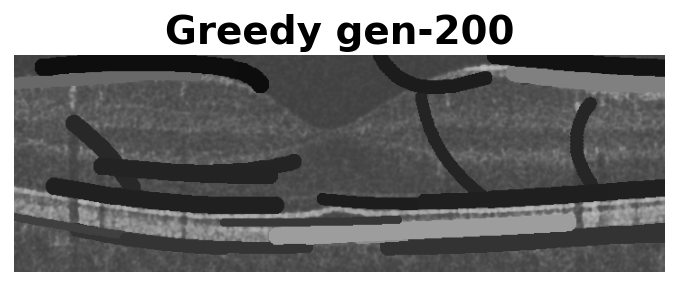

In [28]:
ga.run_generations(100)
ga.plot_clew()

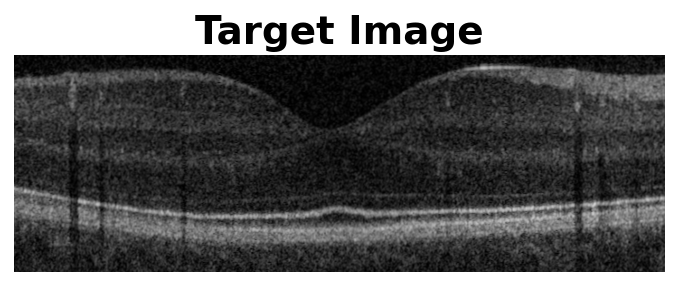

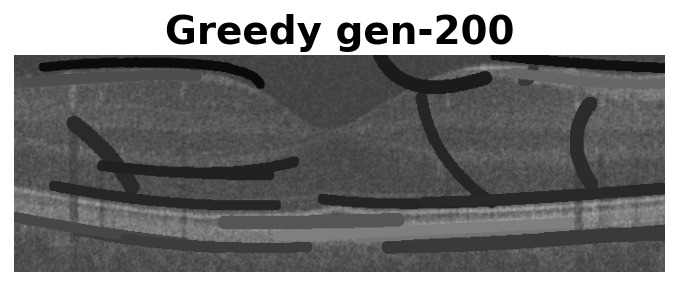

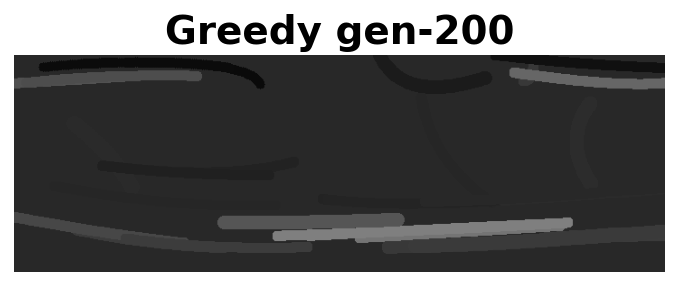

In [29]:
ga_image = ga.image
try:
    ga.image = image
    ga.clew_masks = locally_optimise_clew(ga.image, ga.clew)
    ga.plot_clew(show_target_image=True)
    ga.plot_clew(exclude_background=True)
finally:
    ga.image = ga_image

Generation 201: SSIM = 0.313, Scores = 290 ± 119, [33, 457], Worms = 30  (took 0.69 sec)
Generation 202: SSIM = 0.322, Scores = 310 ± 130, [33, 493], Worms = 30  (took 0.65 sec)
Generation 203: SSIM = 0.325, Scores = 320 ± 137, [33, 515], Worms = 30  (took 0.66 sec)
Generation 204: SSIM = 0.325, Scores = 324 ± 138, [33, 515], Worms = 30  (took 0.66 sec)
Generation 205: SSIM = 0.326, Scores = 328 ± 142, [36, 519], Worms = 30  (took 0.67 sec)
Generation 206: SSIM = 0.326, Scores = 332 ± 146, [36, 550], Worms = 30  (took 0.66 sec)
Generation 207: SSIM = 0.325, Scores = 334 ± 146, [36, 550], Worms = 30  (took 0.66 sec)
Generation 208: SSIM = 0.326, Scores = 336 ± 146, [36, 550], Worms = 30  (took 0.66 sec)
Generation 209: SSIM = 0.326, Scores = 341 ± 149, [36, 550], Worms = 30  (took 0.66 sec)
Generation 210: SSIM = 0.326, Scores = 342 ± 149, [36, 550], Worms = 30  (took 0.66 sec)
Generation 211: SSIM = 0.326, Scores = 342 ± 149, [36, 550], Worms = 30  (took 0.66 sec)
Generation 212: SSIM 

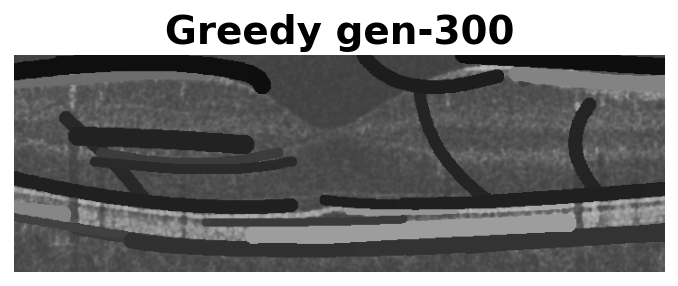

In [30]:
ga.run_generations(100)
ga.plot_clew()

Generation 301: SSIM = 0.347, Scores = 356 ± 166, [44, 620], Worms = 34  (took 0.76 sec)
Generation 302: SSIM = 0.346, Scores = 356 ± 166, [44, 620], Worms = 34  (took 0.77 sec)
Generation 303: SSIM = 0.347, Scores = 357 ± 166, [44, 620], Worms = 34  (took 0.78 sec)
Generation 304: SSIM = 0.347, Scores = 357 ± 166, [44, 620], Worms = 34  (took 0.78 sec)
Generation 305: SSIM = 0.347, Scores = 347 ± 173, [20, 620], Worms = 35  (took 0.86 sec)
Generation 306: SSIM = 0.346, Scores = 351 ± 168, [44, 620], Worms = 35  (took 0.79 sec)
Generation 307: SSIM = 0.346, Scores = 351 ± 167, [44, 620], Worms = 35  (took 0.79 sec)
Generation 308: SSIM = 0.347, Scores = 351 ± 167, [44, 620], Worms = 35  (took 0.79 sec)
Generation 309: SSIM = 0.347, Scores = 352 ± 167, [44, 620], Worms = 35  (took 0.78 sec)
Generation 310: SSIM = 0.347, Scores = 352 ± 167, [44, 620], Worms = 35  (took 0.78 sec)
Generation 311: SSIM = 0.347, Scores = 353 ± 167, [44, 620], Worms = 35  (took 0.79 sec)
Generation 312: SSIM 

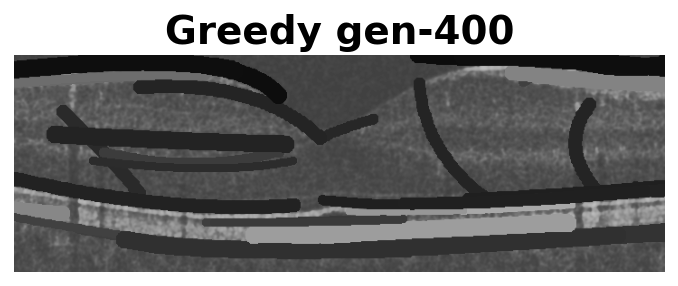

In [31]:
ga.run_generations(100)
ga.plot_clew()

Generation 401: SSIM = 0.351, Scores = 357 ± 165, [44, 620], Worms = 40  (took 0.91 sec)
Generation 402: SSIM = 0.351, Scores = 358 ± 164, [44, 620], Worms = 40  (took 0.91 sec)
Generation 403: SSIM = 0.351, Scores = 358 ± 164, [44, 620], Worms = 40  (took 0.90 sec)
Generation 404: SSIM = 0.351, Scores = 359 ± 163, [44, 620], Worms = 40  (took 0.90 sec)
Generation 405: SSIM = 0.351, Scores = 359 ± 163, [44, 620], Worms = 40  (took 0.90 sec)
Generation 406: SSIM = 0.351, Scores = 359 ± 162, [44, 620], Worms = 40  (took 0.91 sec)
Generation 407: SSIM = 0.351, Scores = 360 ± 162, [44, 620], Worms = 40  (took 0.90 sec)
Generation 408: SSIM = 0.351, Scores = 360 ± 161, [44, 620], Worms = 40  (took 0.91 sec)
Generation 409: SSIM = 0.351, Scores = 361 ± 161, [44, 620], Worms = 40  (took 0.91 sec)
Generation 410: SSIM = 0.351, Scores = 362 ± 160, [44, 620], Worms = 40  (took 0.91 sec)
Generation 411: SSIM = 0.351, Scores = 362 ± 160, [44, 620], Worms = 40  (took 0.91 sec)
Generation 412: SSIM 

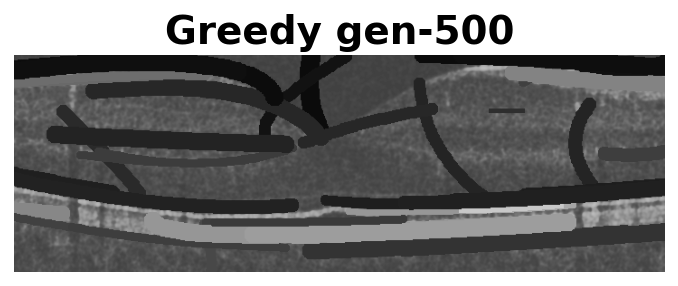

In [32]:
ga.run_generations(100)
ga.plot_clew()

In [33]:
# for i in range(95):
#     ga.run_generations(100)
#     ga.plot_clew()


In [34]:
ga.generate_progress_gif()


gifsicle: warning: trivial adaptive palette (only 154 colors in source)
